In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
!pip install ../forks/tensortrade_source/ -U

Processing c:\users\codeninja\dev\forks\tensortrade_source
  Created wheel for tensortrade: filename=tensortrade-0.1.0rc1-cp37-none-any.whl size=73691 sha256=e6a75917fe2786e9c4054035a039aec03988ae64171284bb2cc56cf794e9d4b0
  Stored in directory: C:\Users\CODENI~1\AppData\Local\Temp\pip-ephem-wheel-cache-a4do99hl\wheels\62\be\3a\90782c795f0ba93fec4a55c551ac7e8f7e7ea933797e4f71c0
Successfully built tensortrade
  Found existing installation: tensortrade 0.1.0rc1
    Uninstalling tensortrade-0.1.0rc1:
      Successfully uninstalled tensortrade-0.1.0rc1


In [7]:
import os
import sys
import warnings
import numpy
import ccxt
import pandas as pd
import numpy as np
from time import time
import math
import cProfile as cp
import matplotlib.pyplot as plt
import pickle

from gym.spaces import Space, Box

config = './neat.config'

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.abspath('')+"\\tensortrade")


**Load Data**

In [4]:

data_file ='./data/processed/binance/btc_usdt_1h.csv' 
df = pd.read_csv(data_file, index_col=[0])


# number of days we want to pull from the dataframe 
days_of_data = 365

# number of data frames (our DF is in 1h timesteps)
frames = days_of_data * 24 * 5
# frames = len(df)
train_test_percentage = 0.4

x_train = int(frames * (1 - train_test_percentage))
x_test = int(frames - x_train)

df_train = df[-frames:(-x_test - 1)]
df_test = df[-x_test:]
print("Friend Shape", df.shape)
print('train shape', df_train.shape)
print('test shape', df_test.shape)
print('columns', df.columns)

Friend Shape (180236, 12)
train shape (26279, 12)
test shape (17520, 12)
columns Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


In [5]:
df_test.head()

,open,high,low,close,volume,momentum_rsi,adx,adx_long,adx_pos,adx_neg,trend_ema_fast,trend_ema_slow
index,,,,,,,,,,,,
2019-08-28 03:35:00,10148.20,10155.65,10140.00,10140.49,103.707956,34.890237,19.680116,9.632237,15.942283,24.099556,10153.780045,10155.268113
2019-08-28 03:40:00,10140.74,10148.78,10125.01,10133.83,73.728054,30.560787,19.729527,9.551850,14.434463,27.784685,10150.710807,10153.680105
2019-08-28 03:45:00,10135.11,10145.87,10120.00,10120.01,102.866752,23.560759,20.578936,9.524416,12.994025,26.944578,10145.987606,10151.186023
2019-08-28 03:50:00,10120.02,10133.51,10116.34,10120.03,55.034065,23.589984,21.604012,9.514225,12.128909,26.569855,10141.994128,10148.878170
2019-08-28 03:55:00,10120.03,10130.00,10119.02,10126.17,48.912488,32.704088,22.726318,9.516439,11.597170,25.405014,10139.559647,10147.196083


**Load Previous Winner**

In [13]:
winner = "winner-1751.bin"
with open("winners/{}".format(winner), "rb") as f:
    winner = pickle.load(winner)

TypeError: file must have 'read' and 'readline' attributes

**Train against training data**

In [27]:
import tensortrade
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
from neat_reward_strategy import NeatRewardStrategy as ProfitStrategy
from tensortrade.actions import DiscreteActions
from tensortrade.exchanges.simulated import SimulatedExchange as Exchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline
from tensortrade.environments import TradingEnvironment as Environment

print('fin imports')
normalize = MinMaxNormalizer(inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize])

reward_scheme = ProfitStrategy()
action_scheme = DiscreteActions(n_actions=5, instrument='BTC/USDT')
print('fin strats')

exchange = Exchange(data_frame=df_train,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.075,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_train.columns
                   )
print('fin exchange')

environment = Environment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)
print('fin environment')
print('')

segments_in_day = 288
days = 7

strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=False,
                           only_show_profitable=False,
                           learn_to_trade_theshold=-10000,
                           data_frame_window = segments_in_day * days
                          )

print("Running through ", strategy._data_frame_window, ' steps')
# cp.run("performance, winner, stats = strategy.run(generations=20)", 'evolution_stats')
performance, winner, stats = strategy.run(generations=50)

fin imports
fin strats
fin exchange
fin environment

Running through  2016  steps

 ****** Running generation 0 ****** 

Population's average fitness: 1.80954 stdev: 2.55681
Best fitness: 11.19080 - size: (13, 169) - species 5 - id 5
Average adjusted fitness: 0.162
Mean genetic distance 3.678, standard deviation 0.748
Population of 200 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    10      3.0    0.268     0
     2    0    10      0.0    0.000     0
     3    0    10      2.0    0.179     0
     4    0    10      0.0    0.000     0
     5    0    10     11.2    1.000     0
     6    0    10      3.0    0.268     0
     7    0    10      3.0    0.268     0
     8    0    10      0.0    0.000     0
     9    0    10      0.0    0.000     0
    10    0    10      3.0    0.268     0
    11    0    10      3.0    0.268     0
    12    0    10      0.0    0.000     0
    13    0    10      0.0    0.000     0
    14   

  ====  ===  ====  =======  =======  ====
     1    6    10      3.0    0.000     6
     2    6    10      3.0    0.000     5
     3    6    10      3.0    0.000     5
     4    6    10      3.0    0.000     5
     5    6    10  10432.1    0.100     0
     6    6    10     13.2    0.001     5
     7    6    10      3.0    0.000     6
     8    6    10      3.0    0.000     5
     9    6    10      2.0    0.000     5
    10    6    10      3.0    0.000     6
    11    6    10      3.0    0.000     6
    12    6    10     11.2    0.000     5
    13    6    10     11.2    0.000     5
    14    6    10      3.0    0.000     5
    15    6    10     11.2    0.000     5
    16    6    10     12.2    0.000     1
    17    6    10      3.0    0.000     6
    18    6    10      0.0    0.000     5
    19    6    10      3.0    0.000     5
    20    6    10      3.0    0.000     6
Total extinctions: 0
Generation time: 267.830 sec (243.773 average)

 ****** Running generation 7 ****** 

Population'

     9   12    10      3.0    0.000    11
    10   12    10      3.0    0.000    12
    11   12    10      3.0    0.000    12
    12   12    10     11.2    0.000    11
    13   12    10     11.2    0.000    11
    14   12    10      3.0    0.000    11
    15   12    10     11.2    0.000    11
    16   12    10     11.2    0.001     7
    17   12    10      3.0    0.000    12
    18   12    10     11.2    0.000    11
    19   12    10      3.0    0.000    11
    20   12    10      3.0    0.000    12
Total extinctions: 0
Generation time: 251.051 sec (263.021 average)

 ****** Running generation 13 ****** 

Population's average fitness: 55.68024 stdev: 743.43219
Best fitness: 10542.95448 - size: (14, 169) - species 5 - id 192
Average adjusted fitness: 0.005
Mean genetic distance 3.678, standard deviation 0.748
Population of 200 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    10      3.0    0.000    13
     2   13   

    18   18    10     11.2    0.000    17
    19   18    10      3.0    0.000    17
    20   18    10      3.0    0.000    18
Total extinctions: 0
Generation time: 251.945 sec (250.745 average)

 ****** Running generation 19 ****** 

Population's average fitness: 2296.84254 stdev: 32359.33703
Best fitness: 458781.46354 - size: (14, 169) - species 5 - id 192
Average adjusted fitness: 0.005
Mean genetic distance 3.678, standard deviation 0.748
Population of 200 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19    10      3.0    0.000    19
     2   19    10      3.0    0.000    18
     3   19    10      3.0    0.000    18
     4   19    10      3.0    0.000    18
     5   19    10  458781.5    0.100     0
     6   19    10     16.2    0.000     8
     7   19    10      3.0    0.000    19
     8   19    10      3.0    0.000    18
     9   19    10      3.0    0.000    18
    10   19    10      3.0    0.000    19
    11  

Best fitness: 9719.22685 - size: (14, 169) - species 5 - id 192
Average adjusted fitness: 0.034
Mean genetic distance 2.699, standard deviation 1.619
Population of 30 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   29    10   9719.2    0.101    10
     6   29    10     16.2    0.001    18
    16   29    10     12.2    0.001     7
Total extinctions: 0
Generation time: 42.539 sec (77.211 average)

 ****** Running generation 30 ****** 

Population's average fitness: 342.17954 stdev: 1802.55479
Best fitness: 10049.19665 - size: (14, 169) - species 5 - id 192
Average adjusted fitness: 0.034
Mean genetic distance 2.699, standard deviation 1.619
Population of 30 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   30    10  10049.2    0.101    11
     6   30    10     16.2    0.001    19
    16   30    10     11.2    0.001     8
Total extinctions: 0
Generation time:

Mean genetic distance 0.882, standard deviation 0.191
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   44    20  10757.5    0.568     5
Total extinctions: 0
Generation time: 43.722 sec (79.588 average)
Saving checkpoint to neat-checkpoint-44

 ****** Running generation 45 ****** 

Population's average fitness: 7080.14582 stdev: 4638.37366
Best fitness: 10532.07632 - size: (17, 173) - species 5 - id 236
Average adjusted fitness: 0.672
Mean genetic distance 0.830, standard deviation 0.185
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   45    20  10532.1    0.672     6
Total extinctions: 0
Generation time: 44.366 sec (80.925 average)

 ****** Running generation 46 ****** 

Population's average fitness: 6133.91696 stdev: 5012.16378
Best fitness: 10642.66560 - size: (15, 170) - species 5 - id 240
Average adjusted fitness: 0.57

Population's average fitness: 6156.82799 stdev: 5027.39314
Best fitness: 10643.14459 - size: (19, 170) - species 5 - id 372
Average adjusted fitness: 0.578
Mean genetic distance 1.110, standard deviation 0.144
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   61    20  10643.1    0.578     2
Total extinctions: 0
Generation time: 44.275 sec (107.824 average)

 ****** Running generation 62 ****** 

Population's average fitness: 6114.78938 stdev: 4995.28650
Best fitness: 10609.80276 - size: (19, 169) - species 5 - id 345
Average adjusted fitness: 0.576
Mean genetic distance 1.066, standard deviation 0.214
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   62    20  10609.8    0.576     3
Total extinctions: 0
Generation time: 44.200 sec (107.781 average)

 ****** Running generation 63 ****** 

Population's average fitness: 6174.3

     5   77    20  10659.0    0.579    18
Total extinctions: 0
Generation time: 45.581 sec (44.958 average)

 ****** Running generation 78 ****** 

Population's average fitness: 7517.21201 stdev: 4344.61362
Best fitness: 10401.39340 - size: (23, 180) - species 5 - id 492
Average adjusted fitness: 0.723
Mean genetic distance 1.254, standard deviation 0.309
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   78    20  10401.4    0.723    19
Total extinctions: 0
Generation time: 45.188 sec (44.964 average)

 ****** Running generation 79 ****** 

Population's average fitness: 307391.49802 stdev: 225890.92099
Best fitness: 494141.15559 - size: (24, 171) - species 5 - id 586
Average adjusted fitness: 0.622
Mean genetic distance 1.259, standard deviation 0.340
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   79    20  494141.2    0.

Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   94    20  10444.9    0.630    15
Total extinctions: 0
Generation time: 44.787 sec (45.250 average)
Saving checkpoint to neat-checkpoint-94

 ****** Running generation 95 ****** 

Population's average fitness: 8612.27608 stdev: 3623.86081
Best fitness: 10769.04655 - size: (25, 183) - species 5 - id 751
Average adjusted fitness: 0.800
Mean genetic distance 1.014, standard deviation 0.242
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   95    20  10769.0    0.800    16
Total extinctions: 0
Generation time: 47.612 sec (45.415 average)

 ****** Running generation 96 ****** 

Population's average fitness: 8198.22082 stdev: 4110.09814
Best fitness: 10830.76369 - size: (26, 176) - species 5 - id 757
Average adjusted fitness: 0.757
Mean genetic distance 0.867, standard deviation 0.28

Population's average fitness: 6011.41550 stdev: 4911.84664
Best fitness: 10482.51937 - size: (28, 184) - species 5 - id 860
Average adjusted fitness: 0.573
Mean genetic distance 1.199, standard deviation 0.227
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  111    20  10482.5    0.573    32
Total extinctions: 0
Generation time: 44.877 sec (45.283 average)

 ****** Running generation 112 ****** 

Population's average fitness: 6664.75944 stdev: 4898.31517
Best fitness: 10858.08811 - size: (29, 186) - species 5 - id 900
Average adjusted fitness: 0.614
Mean genetic distance 1.085, standard deviation 0.253
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  112    20  10858.1    0.614    33
Total extinctions: 0
Generation time: 44.739 sec (45.240 average)

 ****** Running generation 113 ****** 

Population's average fitness: 6682.5

     5  127    20  10541.2    0.626    48
Total extinctions: 0
Generation time: 45.068 sec (107.197 average)

 ****** Running generation 128 ****** 

Population's average fitness: 8078.74023 stdev: 4045.87052
Best fitness: 10692.85814 - size: (33, 175) - species 5 - id 1067
Average adjusted fitness: 0.756
Mean genetic distance 1.425, standard deviation 0.358
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  128    20  10692.9    0.756    49
Total extinctions: 0
Generation time: 46.351 sec (107.354 average)

 ****** Running generation 129 ****** 

Population's average fitness: 6555.02307 stdev: 4811.95595
Best fitness: 10446.99597 - size: (32, 168) - species 5 - id 1060
Average adjusted fitness: 0.627
Mean genetic distance 1.418, standard deviation 0.204
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  129    20  10447.0    0.

Mean genetic distance 1.147, standard deviation 0.345
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  144    20  10779.8    0.763    65
Total extinctions: 0
Generation time: 46.818 sec (108.920 average)
Saving checkpoint to neat-checkpoint-144

 ****** Running generation 145 ****** 

Population's average fitness: 7650.70038 stdev: 4427.17896
Best fitness: 11127.90289 - size: (36, 190) - species 5 - id 1245
Average adjusted fitness: 0.688
Mean genetic distance 1.275, standard deviation 0.380
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  145    20  11127.9    0.688    66
Total extinctions: 0
Generation time: 46.410 sec (108.774 average)

 ****** Running generation 146 ****** 

Population's average fitness: 7710.11731 stdev: 4460.66874
Best fitness: 10818.21137 - size: (38, 183) - species 5 - id 1234
Average adjusted fitnes


Population's average fitness: 7514.57552 stdev: 4344.28417
Best fitness: 10425.23931 - size: (42, 184) - species 5 - id 1407
Average adjusted fitness: 0.721
Mean genetic distance 1.221, standard deviation 0.194
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  161    20  10425.2    0.721    82
Total extinctions: 0
Generation time: 45.859 sec (109.107 average)

 ****** Running generation 162 ****** 

Population's average fitness: 7610.82464 stdev: 4393.53643
Best fitness: 10684.67558 - size: (39, 192) - species 5 - id 1347
Average adjusted fitness: 0.712
Mean genetic distance 1.251, standard deviation 0.328
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  162    20  10684.7    0.712    83
Total extinctions: 0
Generation time: 46.503 sec (108.927 average)

 ****** Running generation 163 ****** 

Population's average fitness: 6

  ====  ===  ====  =======  =======  ====
     5  177    20  10772.9    0.758    98
Total extinctions: 0
Generation time: 47.312 sec (47.751 average)

 ****** Running generation 178 ****** 

Population's average fitness: 7175.27185 stdev: 4704.56309
Best fitness: 10967.26095 - size: (48, 190) - species 5 - id 1570
Average adjusted fitness: 0.654
Mean genetic distance 1.029, standard deviation 0.132
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  178    20  10967.3    0.654    99
Total extinctions: 0
Generation time: 46.161 sec (47.594 average)

 ****** Running generation 179 ****** 

Population's average fitness: 372398.17797 stdev: 186594.73515
Best fitness: 486802.35461 - size: (46, 191) - species 5 - id 1581
Average adjusted fitness: 0.765
Mean genetic distance 0.952, standard deviation 0.265
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =

Average adjusted fitness: 0.847
Mean genetic distance 1.328, standard deviation 0.245
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  194    20  10967.0    0.847   115
Total extinctions: 0
Generation time: 50.437 sec (47.698 average)
Saving checkpoint to neat-checkpoint-194

 ****** Running generation 195 ****** 

Population's average fitness: 8665.82463 stdev: 3641.89228
Best fitness: 10617.58988 - size: (49, 193) - species 5 - id 1713
Average adjusted fitness: 0.816
Mean genetic distance 1.026, standard deviation 0.405
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5  195    20  10617.6    0.816   116
Total extinctions: 0
Generation time: 48.283 sec (47.915 average)

 ****** Running generation 196 ****** 

Population's average fitness: 8713.89100 stdev: 3683.03464
Best fitness: 10972.87803 - size: (51, 197) - species 5 - i

	DefaultConnectionGene(key=(1971, 55), weight=0.14420058404701458, enabled=True)


**Evaluate against full dataset**

In [505]:
 _test_data = df_test[-280*10:90-(280*10)]
exchange = Exchange(data_frame=_test_data,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.075,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_test.columns
                   )
environment = Environment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

environment.reset()
# from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
# exchange.balance = 100000
strategy = strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=True,
                           only_show_profitable=False,
                           full_evaluation=True
                          )
# TradingStrategy(environment=environment, watch_genome_evaluation=True, full_evaluation = True, neat_config=config)

KeyError: <class 'tensortrade.exchanges.simulated.simulated_exchange.SimulatedExchange'>

In [ ]:
environment.reset()
exchange.reset()
exchange._balance = 100
print("Starting Worth: {}".format(exchange.net_worth, exchange.balance))
print(exchange.trades)
strategy.eval_genome(winner, strategy._config)

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
exchange.performance.tail()

In [ ]:
exchange.trades.tail()

In [ ]:
ax = plt.subplot(211)
exchange.performance.net_worth.plot(figsize=(22,8), label='net worth', title='Net Worth')
exchange.performance['com'] = exchange.trades.price*0.00075
ax2 = plt.subplot(212, sharex=ax)
exchange.performance.com.plot(title='Commissions')
plt.legend()

In [ ]:
wins = 0
losses = 0 
ax = plt.subplot(311)

exchange._price_history.plot(figsize=(22,8), label='actual price')
print(_test_data.columns)
_test_data.trend_ema_fast.plot(label='fast ema')
_test_data.trend_ema_slow.plot(label='slow ema')

# print(exchange._price_history.head())
# print(exchange.trades.head())
# print(exchange.performance.head())
for idx,trade in exchange.trades.iterrows():
    price_at_trade = exchange._price_history[trade.step-1]
    if trade.type.is_buy:
        plt.plot(trade.step-1 , price_at_trade, "b^")
    elif trade.type.is_sell:
        the_buy_step = exchange.trades.iloc[idx-1]
        profit = trade.price - the_buy_step.price
        if profit < 0:
            losses +=1
            color = '#d62728'
            plt.axvspan(the_buy_step.step-1, trade.step-1, alpha= 0.5, facecolor='red')
            plt.plot(trade.step-1, price_at_trade, "rD")

        elif profit >= 0:
            wins +=1
            color = '#2ca02c'
            plt.axvspan(the_buy_step.step-1, trade.step-1, alpha= 0.5, facecolor='green')
            plt.plot(trade.step-1, price_at_trade, "gD")

adx = plt.subplot(312, sharex=ax)
_test_data.adx.plot(label='adx')
_test_data.adx_pos.plot(label='pos')
_test_data.adx_neg.plot(label='neg')
_test_data.adx_long.plot(label='long')

_test_data.momentum_rsi.plot(label='rsi')

ax2 = plt.subplot(313, sharex=adx)
exchange.performance.net_worth.plot(title='Net Worth')
ax.legend()


In [497]:
print(wins, losses, len(exchange.trades)/2 )
"Win rate {}%".format((wins/(wins+losses))*100 )


24 12 36.0


'Win rate 66.66666666666666%'

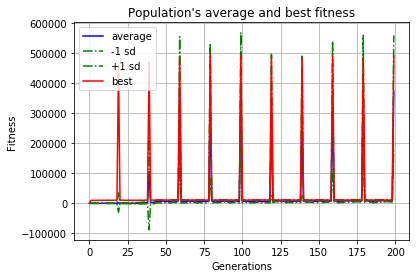

In [230]:
import visualize

visualize.plot_stats(stats, ylog=False, view=True)


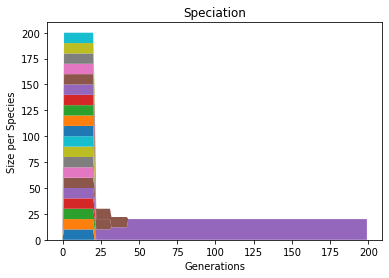

In [33]:
visualize.plot_species(stats, view=True)

In [11]:
visualize.draw_net(strategy._config, winner, False)


NameError: name 'visualize' is not defined

**Save Strategy**

In [96]:
# winner.key
with open("winners/winner-{}.bin".format(winner.key), "wb") as f:
    pickle.dump(winner, f, 2)